In [1]:
import os
from netCDF4 import Dataset as NetCDFFile
import time
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import numpy.ma as ma
from scipy.interpolate import griddata
#from pyresample import geometry,image, kd_tree
import copy
import isamcalc_lib as isam
import C14utils

C:\Users\sshu3\Anaconda2\lib\site-packages\numba\decorators.py:29: NumbaDeprecationWarning: autojit is deprecated, use jit instead, which provides the same functionality. For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-numba-autojit
  warnings.warn(NumbaDeprecationWarning(msg))


In [ ]:
#======== Following codes are for validation ==========#

In [5]:
# Here read in the results and calculate the D14C for each layer
fsample = 'Global_0DSBGC_NOCLIM.bgc-yearly-d14c-3d_2000s.nc'
nclu_obs=NetCDFFile(fsample,'r')
d14c = nclu_obs.variables['soc_d_c14'][:]
nclu_obs.close()

# LC data
flc = 'verify_time_invarient.nc'
nclu_obs=NetCDFFile(flc,'r')
lc = nclu_obs.variables['c_pft_fraction'][:]
nclu_obs.close()

# Need to get the mask to prevent running for useless grids.
fdv = 'dave_mask.nc'
nclu_obs=NetCDFFile(fdv,'r')
dv_msk = nclu_obs.variables['Davemask'][:]
nclu_obs.close()

# D14C is not possible to use PFT as weight.
# Need to get the 14C/12C ratio then use PFT as a weight.
rc14c12 = d14c/1000. + 1

rc14c12_all = np.sum((rc14c12 * lc), axis=0)
d14c_all = 1000.*(rc14c12_all - 1)

d14c_all[d14c_all>1000] = np.float('nan')
d14c_all[d14c_all<-1000] = np.float('nan')

# Get a mask to filter out grids with no values
msk = d14c_all[:,:]
msk[dv_msk>0] = np.float('nan')

print 'Done the averaging!'

tau_soil = np.zeros((360, 720))

# Calculate the tau, one time for a lat
# Lat starts from 360 to 220 (20N ~ 80N), Dave Mcguire's regional mask is applied
# First transfer into a 1-D array then pass into cal_tau?
for i in np.arange(359,219,-1):
    print i
    # Weighted C14 for topsoil and subsoil separatedly
    # Preindustrial year - 1860
    # Contemporary year - 2010
    msk_inuse = msk[i,:]
    sampleyr = 2005*np.ones((720))
    sampleyr[np.isnan(msk_inuse)] = np.float('nan')
    sampleyr[msk_inuse<-100] = np.float('nan')
    # Calculate the turnover time
    tau, cost = C14utils.cal_tau(d14c_all[i,:], sampleyr, 1, 0)
    tau_soil[i,:] = tau[:,0]

tau_soil[tau_soil>3000] = np.float('nan')

# Save the file as netcdf for display
# Create a NetCDF file to store the result
nc = NetCDFFile('tau_0d_2000s_NOCLIM.nc','w',format='NETCDF4_CLASSIC')
# Define a set of dimensions to be used in the file
lat = nc.createDimension('lat', 360)
lon = nc.createDimension('lon', 720)
# Create variables
latitudes = nc.createVariable('lat', np.float32, ('lat',))
longitudes = nc.createVariable('lon', np.float32, ('lon',))
# Create the actual 4-d variable
tau_1m = nc.createVariable('tau_1m', np.float32, ('lat','lon'))

# Add Global Attributes
nc.description = 'Tau calculated from the Soil D14C.'
nc.history = 'Created ' + time.ctime(time.time())
nc.source = 'netCDF4 python module'

# Add Variable Attributes
latitudes.units = 'degree_north'
longitudes.units = 'degree_east'
tau_1m.units = 'year'

# Put longitude and latitude
lats = np.arange(-89.75,90.25,0.5)
lons = np.arange(0.25,360.25,0.5)
latitudes[:] = lats
longitudes[:] = lons
tau_1m[:,:] = tau_soil
nc.close()

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less


Done the averaging!
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220


In [ ]:
fsample = 'Global_0DSBGC.bgc-yearly-d14c-3d_1860s.nc'
nclu_obs=NetCDFFile(fsample,'r')
abg_soc = nclu_obs.variables['agc'][:]
abg_soc14 = nclu_obs.variables['agc14'][:]
blg_soc = nclu_obs.variables['bgc'][:]
blg_soc14 = nclu_obs.variables['bgc14'][:]
nclu_obs.close()


In [ ]:
np.shape(abg_soc)

In [2]:
# fsample = 'Global_0DSBGC.bgc-yearly-d14c-3d_1860s.nc'
fsample = 'Global_0DSBGC.bgc-yearly-d14c-3d_2000s.nc'
# fsample = 'Global_0DSBGC_NOCLIM.bgc-yearly-d14c-3d_2000s.nc'
# fsample = 'Global_0DSBGC_NOCO2.bgc-yearly-d14c-3d_2000s.nc'
nclu_obs=NetCDFFile(fsample,'r')
abg_soc = nclu_obs.variables['agc'][:]
abg_soc14 = nclu_obs.variables['agc14'][:]
blg_soc = nclu_obs.variables['bgc'][:]
blg_soc14 = nclu_obs.variables['bgc14'][:]
input_flux = nclu_obs.variables['input_pools'][:]
resp_flux = nclu_obs.variables['resp_pools'][:]
nclu_obs.close()

# Need to get the mask to prevent running for useless grids.
fdv = 'dave_mask.nc'
nclu_obs=NetCDFFile(fdv,'r')
dv_msk = nclu_obs.variables['Davemask'][:]
nclu_obs.close()

# Another mask if choose to use NCSCD
path='ncscdv2_soilc_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
latnc2 = nclu_obs.variables['lat'][:]
lonnc2 = nclu_obs.variables['lon'][:]
nclu_obs.close()
soc_ncscd = soc_ncscd_orig[0,:,:]
# Use the NCSCD permafrost mask, which is the norther high latitude permafrost region without greenland
# The mask Mcguire et al., 2016 used including alpine permafrost (Tiebet and the Alps)
# Alpine permafrost to be treated as having a very small amount of SOC, though for the paper we have 
# to consider the whole region.
mask_permafrost = copy.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = copy.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = copy.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp

# Calculate the D14C of lab and res pools
abg_soc[abg_soc<=0] = np.float('nan')
abg_soc14[abg_soc14<=0] = np.float('nan')
blg_soc[blg_soc<=0] = np.float('nan')
blg_soc14[blg_soc14<=0] = np.float('nan')

soc_temp = np.ones((9, 360, 720))*float("nan")
soc_temp[0:4,:,:] = abg_soc
soc_temp[4:9,:,:] = blg_soc
soc = ma.masked_array(soc_temp)

d14c_lab = 1000.*((np.nansum(abg_soc14[:,:,:], axis=0)+np.nansum(blg_soc14[0:3,:,:], axis=0))/(np.nansum(abg_soc[:,:,:], axis=0)+np.nansum(blg_soc[0:3,:,:], axis=0)) - 1)
d14c_res = 1000.*(blg_soc14[3,:,:]/blg_soc[3,:,:] - 1)


In [3]:
# Calculate STT from D14C
tau_topsoil = np.zeros((360, 720))
tau_subsoil = np.zeros((360, 720))
msk = d14c_lab[:,:]
msk[dv_msk>0] = -1000

# Calculate the tau, one time for a lat
# Lat starts from 360 to 220 (20N ~ 80N), Dave Mcguire's regional mask is applied
# First transfer into a 1-D array then pass into cal_tau?
for i in np.arange(359,219,-1):
    print(i)
    # Weighted C14 for topsoil and subsoil separatedly
    # Preindustrial year - 1860
    # Contemporary year - 2000
    msk_inuse = msk[i,:]
    sampleyr = 2005*np.ones((720))
    sampleyr[msk_inuse<-400] = np.float('nan')
    # Calculate the turnover time
    tau, cost = C14utils.cal_tau(d14c_lab[i,:], sampleyr, 1, 0)
    tau_topsoil[i,:] = tau[:,0]
    tau, cost = C14utils.cal_tau(d14c_res[i,:], sampleyr, 1, 0)
    tau_subsoil[i,:] = tau[:,0]

tau_topsoil[tau_topsoil>1000] = np.float('nan')
tau_subsoil[tau_subsoil>3000] = np.float('nan')

# Save the file as netcdf for display
# Create a NetCDF file to store the result
nc = NetCDFFile('tau_0d_2000s_res_lab.nc','w',format='NETCDF4_CLASSIC')
# Define a set of dimensions to be used in the file
#level = nc.createDimension('level', 10)
lat = nc.createDimension('lat', 360)
lon = nc.createDimension('lon', 720)
# Create variables
#levels = nc.createVariable('level', np.int32, ('level',))
latitudes = nc.createVariable('lat', np.float32, ('lat',))
longitudes = nc.createVariable('lon', np.float32, ('lon',))
# Create the actual 4-d variable
tau_top = nc.createVariable('tau_lab', np.float32, ('lat','lon'))
tau_sub = nc.createVariable('tau_res', np.float32, ('lat','lon'))

# Add Global Attributes
nc.description = 'Tau calculated from the Soil D14C.'
nc.history = 'Created ' + time.ctime(time.time())
nc.source = 'netCDF4 python module'

# Add Variable Attributes
latitudes.units = 'degree_north'
longitudes.units = 'degree_east'
tau_top.units = 'year'
tau_sub.units = 'year'

# Put longitude and latitude
lats = np.arange(-89.75,90.25,0.5)
lons = np.arange(0.25,360.25,0.5)
latitudes[:] = lats
longitudes[:] = lons
tau_top[:,:] = tau_topsoil
tau_sub[:,:] = tau_subsoil
nc.close()

359


C14utils.py:55: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cal_tau" failed type inference due to: Unknown attribute 'loadmat' of type Module(<module 'scipy.io' from 'C:\Users\sshu3\Anaconda2\lib\site-packages\scipy\io\__init__.pyc'>)

File "C14utils.py", line 69:
def cal_tau(d14c, smpyr, savecostn, tauonly):
    <source elided>
    tauslow = np.arange(2000, 200000, 5)
    atm14C = scipy.io.loadmat('atmD14C_50kBP-2012.mat')
    ^

[1] During: typing of get attribute at C14utils.py (69)

File "C14utils.py", line 69:
def cal_tau(d14c, smpyr, savecostn, tauonly):
    <source elided>
    tauslow = np.arange(2000, 200000, 5)
    atm14C = scipy.io.loadmat('atmD14C_50kBP-2012.mat')
    ^

  @autojit
C14utils.py:55: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "cal_tau" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "C14uti

358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220


In [46]:
# Calculate the input flux, resp flux, SOC and STT for the ISAM-0D. ISAM-0D_NOCLIM and ISAM-0D_NOCO2
input_lab = np.nansum(input_flux[0:2,:,:], axis=0) + np.nansum(input_flux[4:6,:,:], axis=0)
input_res = input_flux[7,:,:]

resp_lab = np.nansum(resp_flux[0:7,:,:], axis=0)
resp_res = resp_flux[7,:,:]

soc_lab = np.nansum(soc[0:7,:,:], axis=0)
soc_res = soc[7,:,:]


In [10]:
type(abg_soc)

numpy.ma.core.MaskedArray

In [47]:
# Obtain areal total
# First masked values outside our mask
input_lab[input_lab<=0] = np.float('nan')
input_res[input_res<=0] = np.float('nan')

resp_lab[resp_lab<=0] = np.float('nan')
resp_res[resp_res<=0] = np.float('nan')

input_lab.mask = another_mask.mask
input_res.mask = another_mask.mask

resp_lab.mask = another_mask.mask
resp_res.mask = another_mask.mask

soc_lab.mask = another_mask.mask
soc_res.mask = another_mask.mask

# soc_lab = ma.masked_array(soc_lab, mask=another_mask)
# soc_res = ma.masked_array(soc_res, mask=another_mask)

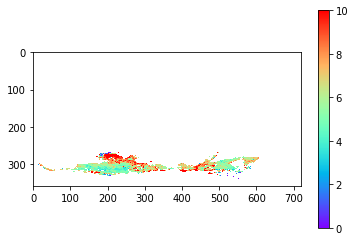

In [41]:
plt.imshow(soc_res, cmap='rainbow',vmin=0, vmax=10)
plt.colorbar()

In [48]:
# Input C fluxes
# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
val_lab = np.ones((nlat, nlon))*float("nan")
val_res = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)
        val_lab[i,j] = input_lab[i,j] * grid_area[i,j]
        val_res[i,j] = input_res[i,j] * grid_area[i,j]

input_lab_tot = np.nansum(val_lab)/1e12
input_res_tot = np.nansum(val_res)/1e12

print('Input labile ...')
print(input_lab_tot)
print('Input resistant ...')
print(input_res_tot)


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Warning: converting a masked element to nan.
  from ipykernel import kernelapp as app
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Warning: converting a masked element to nan.
  app.launch_new_instance()


Input labile ...
2.97277648748418
Input resistant ...
0.6596369213661576


In [49]:
# Respiration C fluxes
# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
val_lab = np.ones((nlat, nlon))*float("nan")
val_res = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)
        val_lab[i,j] = resp_lab[i,j] * grid_area[i,j]
        val_res[i,j] = resp_res[i,j] * grid_area[i,j]

resp_lab_tot = np.nansum(val_lab)/1e12
resp_res_tot = np.nansum(val_res)/1e12

print('Respiration labile ...')
print(resp_lab_tot)
print('Respiration resistant ...')
print(resp_res_tot)


C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Warning: converting a masked element to nan.
  from ipykernel import kernelapp as app
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Warning: converting a masked element to nan.
  app.launch_new_instance()


Respiration labile ...
2.4686392887190913
Respiration resistant ...
0.565342301485574


In [50]:
# SOC
# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
val_lab = np.ones((nlat, nlon))*float("nan")
val_res = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)
        val_lab[i,j] = soc_lab[i,j] * grid_area[i,j]
        val_res[i,j] = soc_res[i,j] * grid_area[i,j]

soc_lab_tot = np.nansum(val_lab)/1e12
soc_res_tot = np.nansum(val_res)/1e12

print('SOC labile ...')
print(soc_lab_tot)
print('SOC resistant ...')
print(soc_res_tot)

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Warning: converting a masked element to nan.
  from ipykernel import kernelapp as app
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Warning: converting a masked element to nan.
  app.launch_new_instance()


SOC labile ...
30.730176362250248
SOC resistant ...
124.42669499505772


In [ ]:
plt.imshow(d14c_res,cmap='rainbow',vmin=-600, vmax=200)
plt.colorbar()

In [ ]:
plt.imshow(d14c_lab,cmap='rainbow',vmin=-100, vmax=200)
plt.colorbar()

In [ ]:
## OLD METHOD seems not working... I now changed to use the calculated D14C for calculating back the soc14 based on soc of the new initial file
# 2. Obtain the C and 14C content 
# Open SBGC restart

#path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscd_masked_0.5x0.5.nc'
nclu_obs=NetCDFFile(fc14,'r')
agcbox = nclu_obs.variables['agcbox'][:]
bgcbox = nclu_obs.variables['bgcbox'][:]
agcprof = nclu_obs.variables['agcprof'][:]
bgcprof = nclu_obs.variables['bgcprof'][:]
agc14box = nclu_obs.variables['agc14box'][:]
bgc14box = nclu_obs.variables['bgc14box'][:]
agc14prof = nclu_obs.variables['agc14prof'][:]
bgc14prof = nclu_obs.variables['bgc14prof'][:]
latnc = nclu_obs.variables['lat'][:]
lonnc = nclu_obs.variables['lon'][:]
nclu_obs.close()

nclu_obs=NetCDFFile(fbgc,'r')
agcbox_new = nclu_obs.variables['agcbox'][:]
bgcbox_new = nclu_obs.variables['bgcbox'][:]
agcprof_new = nclu_obs.variables['agcprof'][:]
bgcprof_new = nclu_obs.variables['bgcprof'][:]
agc14box_new = nclu_obs.variables['agc14box'][:]
bgc14box_new = nclu_obs.variables['bgc14box'][:]
agc14prof_new = nclu_obs.variables['agc14prof'][:]
bgc14prof_new = nclu_obs.variables['bgc14prof'][:]
nclu_obs.close()

soc14_agc = np.zeros((10,24,4,360,720))
soc14_bgc = np.zeros((10,24,5,360,720))
soc_agc = np.zeros((10,24,4,360,720))
soc_bgc = np.zeros((10,24,5,360,720))
soc14_agc_new = np.zeros((10,24,4,360,720))
soc14_bgc_new = np.zeros((10,24,5,360,720))
soc_agc_new = np.zeros((10,24,4,360,720))
soc_bgc_new = np.zeros((10,24,5,360,720))

# 3. Calculate back soc and soc14 profiles
for lev in np.arange(0,10):
    soc14_agc[lev,:,:,:,:] = agc14box * agc14prof[lev,:,:,:,:]/10000.
    soc14_bgc[lev,:,:,:,:] = bgc14box * bgc14prof[lev,:,:,:,:]/10000.
    soc_agc[lev,:,:,:,:] = agcbox * agcprof[lev,:,:,:,:]/10000.
    soc_bgc[lev,:,:,:,:] = bgcbox * bgcprof[lev,:,:,:,:]/10000.

c14c12_agc = soc14_agc/soc_agc
c14c12_bgc = soc14_bgc/soc_bgc

# Change the soc14 profiles based on the c14/c12 and soc profiles
for lev in np.arange(0,10):
    soc_agc_new[lev,:,:,:,:] = agcbox_new * agcprof[lev,:,:,:,:]/10000.
    soc_bgc_new[lev,:,:,:,:] = bgcbox_new * bgcprof[lev,:,:,:,:]/10000.

soc14_agc_new = c14c12_agc * soc_agc_new
soc14_bgc_new = c14c12_bgc * soc_bgc_new

# 4. Update the SOC14 pool size after getting the new profile
soc14_agc_tot = np.nansum(soc14_agc_new, axis=0)
soc14_bgc_tot = np.nansum(soc14_bgc_new, axis=0)

# Calculate the new profile factor
soc14_agcprof_new = np.zeros((10,24,4,360,720))
soc14_bgcprof_new = np.zeros((10,24,5,360,720))
for lev in np.arange(0,10):
    soc14_agcprof_new[lev,:,:,:,:] = soc14_agc_new[lev,:,:,:,:]/soc14_agc_tot * 10000.
    soc14_bgcprof_new[lev,:,:,:,:] = soc14_bgc_new[lev,:,:,:,:]/soc14_bgc_tot * 10000.
soc14_agcprof_new[soc14_agcprof_new<0]=0
soc14_bgcprof_new[soc14_bgcprof_new<0]=0
#soc14_agcprof_new.astype('int')
#soc14_bgcprof_new.astype('int')

# 5. Store back the SOC14 into the restart file
fout = 'bgc.isam_initial.1dbgc_new.nc'
nclu_obs=NetCDFFile(fout,'a')
nclu_obs.variables['agc14prof'][:] = soc14_agcprof_new.astype('int')
nclu_obs.variables['bgc14prof'][:] = soc14_bgcprof_new.astype('int')
nclu_obs.variables['agc14box'][:] = soc14_agc_tot
nclu_obs.variables['bgc14box'][:] = soc14_bgc_tot
nclu_obs.close()


In [ ]:
# Make Plot
# Can continue later
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(30,24))

ax1 = fig.add_subplot(231)
ax1.set_title("ISAM-1D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
xs, ys = np.meshgrid(lonnc3, latnc3)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,soc_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
# Overlap scatter plot to show the peatland distribution
#map.scatter(xs, ys, s = 4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 4*histel, latlon=True, marker='_', color='cyan')
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
plt.annotate('(a)', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#parallels = np.arange(45.,80.,15.)
## labels = [left,right,top,bottom]
#map.drawparallels(parallels)#,labels=[False,True,True,False])
#meridians = np.arange(15.,346.,30.)
#map.drawmeridians(meridians)#,labels=[True,False,False,True])

map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=30) 

ax2 = fig.add_subplot(232)
ax2.set_title("ISAM-0D SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,soc0d_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
#map.scatter(xs, ys, s = 0.4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 0.4*histel, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=32, labelpad=10)
plt.annotate('(b)', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=30) 

lon2,lat2 = np.meshgrid(lonnc2,latnc2) #Returns coordinate matrices from coordinate vectors
x2,y2 = map(lon2,lat2)
ax2 = fig.add_subplot(233)
ax2.set_title("NCSCD SOC stock (1m)",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x2,y2,soc_ncscd_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
                                                     # omit this to use linear
                                                     # color scale
#map.scatter(xs, ys, s = 0.4*histosol, latlon=True, marker='_', color='cyan')
#map.scatter(xs, ys, s = 0.4*histel, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
plt.annotate('(c)', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=30) 

ax3 = fig.add_subplot(234)
ax3.set_title("ISAM-1D SOC turnover time",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,tau_contemp_perm[:,:],
              norm=colors.LogNorm(vmin=1,vmax=1500.),cmap=plt.cm.summer) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs,ticks=[1, 10, 100, 1000, 5000],location='bottom',pad="5%",extend='both', format=ticker.LogFormatter())
plt.annotate('(a)', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.set_xticklabels([0, 200, 400, 600, 800])  # horizontal colorbar
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=30) 

ax3 = fig.add_subplot(235)
ax3.set_title("ISAM-0D SOC turnover time",fontsize=32,pad=15)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,tau0d_contemp_perm[:,:],
              norm=colors.LogNorm(vmin=1,vmax=1500.),cmap=plt.cm.summer) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs,ticks=[1, 10, 100, 1000, 5000],location='bottom',pad="5%",extend='both', format=ticker.LogFormatter())
cbar.ax.set_xlabel('Unit: year', fontsize=32, labelpad=10)
plt.annotate('(b)', fontsize=32, xy=(0.1, 0.9), xycoords='axes fraction')
#cbar.ax.set_xticklabels([0, 200, 400, 600, 800])  # horizontal colorbar
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=30) 

#plt.show()
plt.savefig('./figures/fig6.png',dpi=300)

In [ ]:
plt.imshow(soc_contemp_perm)

In [ ]:
soc_contemp_perm = copy.deepcopy(soc_contemp)

In [ ]:
plt.imshow(dsoc)

In [ ]:
# Mask all regions outside the northern permafrost extent
dsoc_perm = copy.deepcopy(dsoc)
dsoc_perm.mask = another_mask.mask
dsoc0d_perm = copy.deepcopy(dsoc0d)
dsoc0d_perm.mask = another_mask.mask
dtau_perm = copy.deepcopy(dtau)
dtau_perm.mask = another_mask.mask
dtau0d_perm = copy.deepcopy(dtau0d)
dtau0d_perm.mask = another_mask.mask

# Plot the figure7
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(18,15))

#ax1 = fig.add_subplot(331)
ax1 = fig.add_subplot(221)
ax1.set_title("ISAM-1D SOC stock (2009 - 1960)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,dsoc_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.coolwarm) # use log color scale,
cbar = map.colorbar(cs1,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM-0D SOC stock (2009 - 1960)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs2 = map.pcolormesh(x,y,dsoc0d_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.coolwarm) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs2,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=0)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 


ax3 = fig.add_subplot(223)
ax3.set_title("ISAM-1D SOC turnover time (2009 - 1960)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs3 = map.pcolormesh(x,y,dtau_perm[:,:],
#              norm=colors.Normalize(vmin=-300,vmax=300.),cmap=plt.cm.coolwarm) # use log color scale,
              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.coolwarm) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs3,ticks=[-100, -10, -1, 0, 1, 10, 100],location='bottom',pad="5%",extend='both', format=ticker.LogFormatter())
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(c)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(224)
ax4.set_title("ISAM-0D SOC turnover time (2009 - 1960)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs4 = map.pcolormesh(x,y,dtau0d_perm[:,:],
#              norm=colors.Normalize(vmin=-60.,vmax=60.),cmap=plt.cm.coolwarm) # use log color scale,
              norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-300, vmax=300),cmap=plt.cm.coolwarm) # use log color scale,

cbar = map.colorbar(cs4,ticks=[-100, -10, -1, 0, 1, 10, 100],location='bottom',pad="5%",extend='both', format=ticker.LogFormatter())
cbar.ax.set_xlabel('Unit: $year$', fontsize=20, labelpad=0)
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
plt.annotate('(d)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')
cbar.ax.tick_params(labelsize=22) 

#plt.show()
plt.savefig('./figures/fig7.png',dpi=300)

In [ ]:
dsoc_top_perm = soc_top_contemp_perm - soc_top_preind_perm
dsoc_sub_perm = soc_sub_contemp_perm - soc_sub_preind_perm

fig = plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(121)
#ax1.set_title("ISAM 1D topsoil SOC change (kgC/m2)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,dsoc_top_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.coolwarm) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
plt.annotate('(a)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

ax2 = fig.add_subplot(122)
#ax2.set_title("ISAM 1D subsoil SOC change (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,dsoc_sub_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.coolwarm) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,ticks=[-2, -1, 0, 1, 2],location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 
cbar.ax.set_xlabel('Unit: $kgC m^{-2}$', fontsize=20, labelpad=10)
plt.annotate('(b)', fontsize=24, xy=(0.1, 0.9), xycoords='axes fraction')

# Set one colorbar for both subplots
# make an axes to put the shared colorbar in
#fig.subplots_adjust(bottom=0.1)
#colorbar_axes = plt.gcf().add_axes([0.35, 0.1, 0.3, 0.05])
#colorbar = plt.colorbar(cs, colorbar_axes, orientation='horizontal')
#colorbar_axes.tick_params(labelsize=20) 
#colorbar.set_label('Unit: $KgC m^{-2}$', fontsize=24)

#plt.show()
plt.savefig('./figures/fig8.png',dpi=300)

In [ ]:
# Plot the figure3
# Mask all regions outside the northern permafrost extent
resp_contemp_perm = copy.deepcopy(resp_contemp)
resp_contemp_perm.mask = another_mask.mask
resp0d_contemp_perm = copy.deepcopy(resp0d_contemp)
resp0d_contemp_perm.mask = another_mask.mask
resp_preind_perm = copy.deepcopy(resp_preind)
resp_preind_perm.mask = another_mask.mask
resp0d_preind_perm = copy.deepcopy(resp0d_preind)
resp0d_preind_perm.mask = another_mask.mask
dresp_perm = copy.deepcopy(dresp)
dresp_perm.mask = another_mask.mask
dresp0d_perm = copy.deepcopy(dresp0d)
dresp0d_perm.mask = another_mask.mask

# Comparison of Soil respiration and the change
fig = plt.figure(figsize=(18,15))

ax1 = fig.add_subplot(221)
ax1.set_title("ISAM 0D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,1000.*resp0d_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM 0D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp0d_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax3 = fig.add_subplot(223)
ax3.set_title("ISAM 1D Heterotrophic respiration (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*resp_contemp_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

ax4 = fig.add_subplot(224)
ax4.set_title("ISAM 1D change of Rh (gC/m2/year)",fontsize=20,pad=10)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp_perm[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=80.),cmap=plt.cm.RdYlGn_r) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

plt.show()
#plt.savefig('Fig9.jpg',dpi=300)